# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:
1) модель с 1 GRU слоем;
2) модель с 1 LSTM слоем
3) модель с 1 GRU и 1 LSTM слоем
4) модель с 1 BIGRU и 2 LSTM слоями
5) модель с 5 GRU слоями и 3 LSTM слоями
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

**Подгрузка данных**

In [2]:
import pandas as pd
data = pd.read_csv('lenta_40k.csv.zip')
data.dropna(subset=['topic', 'text'], inplace=True)

In [3]:
data.head()

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


**Вспомогательное**

In [4]:
import tensorflow as tf

In [32]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**Обработка данных**

In [16]:
from collections import Counter
from string import punctuation

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

vocab = Counter()

data['preprocess'] = data.text.apply(preprocess)

for text in data.preprocess:
    vocab.update(text)

filtered_vocab = set([word for word in vocab if vocab[word] > 30])
word2id = {word: i + 1 for i, word in enumerate(filtered_vocab)}
word2id['PAD'] = 0
id2word = {i: word for word, i in word2id.items()}

def text_in_idx_generator(texts):
    global word2id
    for l in texts:
        yield [word2id[token] for token in l if token in word2id]

X = list(text_in_idx_generator(data.preprocess))
MAX_LEN = 200
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [17]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

**Обучающая + тестовая выборки**

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

**модель с 1 GRU слоем**

In [34]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

**модель с 1 LSTM слоем**

In [35]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

**модель с 1 GRU и 1 LSTM слоем**

In [36]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
rnn = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
rnn = tf.keras.layers.LSTM(128, return_sequences=False)(rnn)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

**модель с 1 BIGRU и 2 LSTM слоями**

In [37]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
rnn = tf.keras.layers.LSTM(128, return_sequences=True)(rnn)
rnn = tf.keras.layers.LSTM(128, return_sequences=False)(rnn)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model4 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

**модель с 5 GRU слоями и 3 LSTM слоями**

In [38]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
rnn = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
for _ in range(4):
    rnn = tf.keras.layers.GRU(128, return_sequences=True)(rnn)
for _ in range(2):
    rnn = tf.keras.layers.LSTM(128, return_sequences=True)(rnn)
rnn = tf.keras.layers.LSTM(128, return_sequences=False)(rnn)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model5 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model5.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

**модель 1 BIGRU и 1 BILSTM слоями**

In [39]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(rnn)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model6.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

**LSTM, GRU, BILSTM, BIGRU, GRU, LSTM**

In [40]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
rnn = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
rnn = tf.keras.layers.GRU(128, return_sequences=True)(rnn)
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(rnn)
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(rnn)
rnn = tf.keras.layers.LSTM(128, return_sequences=False)(rnn)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model7 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model7.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

**Обучение моделей**

In [41]:
models = [model1,
          model2,
          model3,
          model4,
          model5,
          model6,
          model7]

index = ["1-GRU", "1-LSTM", "1-GRU+1-LSTM", "1-BIGRU+2-LSTM", "5-GRU+3-LSTM", "1-BIGRU+1-BILSTM",
         "LSTM+GRU+BILSTM+BIGRU+GRU+LSTM"]

with open('results.csv', 'w', encoding='utf-8') as file:
    file.write('model,train_f1,train_loss,val_f1,val_loss\n')

for i, m in enumerate(models):
    history = m.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=200,
                    epochs=8)
    f1_sc = history.history['f1'][-1]
    loss = history.history['loss'][-1]
    val_f1 = history.history['val_f1'][-1]
    val_loss = history.history['val_loss'][-1]
    with open('results.csv', 'a', encoding='utf-8') as file:
        scores = [f1_sc, loss, val_f1, val_loss]
        scores = list(map(lambda x: str(round(x, 3)), scores))
        scores = [index[i]] + scores
        file.write(','.join(scores))
        file.write('\n')

Epoch 1/8
211/211 [==============================] - 40s 173ms/step - loss: 2.2685 - f1: 0.0049 - rec@prec: 9.4926e-05 - val_loss: 1.8875 - val_f1: 0.0504 - val_rec@prec: 0.0311
Epoch 2/8
211/211 [==============================] - 27s 126ms/step - loss: 1.5401 - f1: 0.3309 - rec@prec: 0.1972 - val_loss: 1.3465 - val_f1: 0.5476 - val_rec@prec: 0.4022
Epoch 3/8
211/211 [==============================] - 17s 80ms/step - loss: 1.0596 - f1: 0.6471 - rec@prec: 0.5598 - val_loss: 1.1835 - val_f1: 0.6481 - val_rec@prec: 0.5302
Epoch 4/8
211/211 [==============================] - 14s 67ms/step - loss: 0.7302 - f1: 0.7698 - rec@prec: 0.7648 - val_loss: 1.1261 - val_f1: 0.6643 - val_rec@prec: 0.5541
Epoch 5/8
211/211 [==============================] - 11s 51ms/step - loss: 0.5224 - f1: 0.8395 - rec@prec: 0.8734 - val_loss: 1.1439 - val_f1: 0.6901 - val_rec@prec: 0.5978
Epoch 6/8
211/211 [==============================] - 9s 42ms/step - loss: 0.3594 - f1: 0.8950 - rec@prec: 0.9400 - val_loss: 1.22

In [47]:
res = pd.read_csv('results.csv')
res

,model,train_f1,train_loss,val_f1,val_loss
0,1-GRU,0.952,0.177,0.684,1.448
1,1-LSTM,0.893,0.380,0.724,1.100
2,1-GRU+1-LSTM,0.871,0.450,0.697,1.168
3,1-BIGRU+2-LSTM,0.750,0.802,0.672,1.167
4,5-GRU+3-LSTM,0.000,2.323,0.000,2.320
5,1-BIGRU+1-BILSTM,0.894,0.366,0.705,1.208
6,LSTM+GRU+BILSTM+BIGRU+GRU+LSTM,0.842,0.542,0.707,1.071


**Вывод:**

все модели отработали достаточно хорошо, давая на тестовой выборке точность порядка 70 %. Лучше всего себя показала однослойная лстм-модель. Также хороша последняя модель (LSTM+GRU+BILSTM+BIGRU+GRU+LSTM), возможно при большем количестве эпох она сошлась бы лучше однослойной лстм модели.

К сожалению, модель с 5-ю GRU слоями и 3-мя LSTM слоями не обучилась.

**Графики ф-меры для моделей**

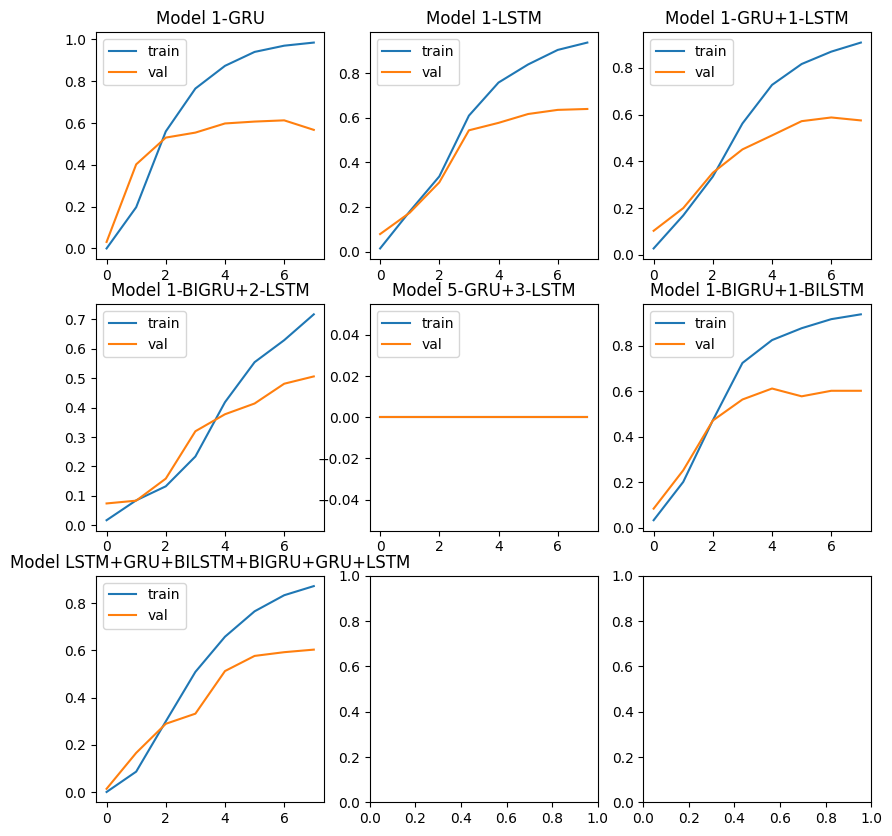

In [61]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(3, 3, figsize=[10, 10])
j = 0

for i, m in enumerate(models):
# summarize history for accuracy
    axis[j, i%3].plot(m.history.history['rec@prec'])
    axis[j, i%3].plot(m.history.history['val_rec@prec'])
    #axis[j, i%3].title('model f1')
    #axis[j, i%3].ylabel('f1')
    #axis[j, i%3].xlabel('epoch')
    axis[j, i%3].legend(['train', 'val'], loc='upper left')
    axis[j, i%3].set_title(f"Model {index[i]}")
    if i % 3 == 2:
        j += 1

plt.show()

**Графики функции потерь**

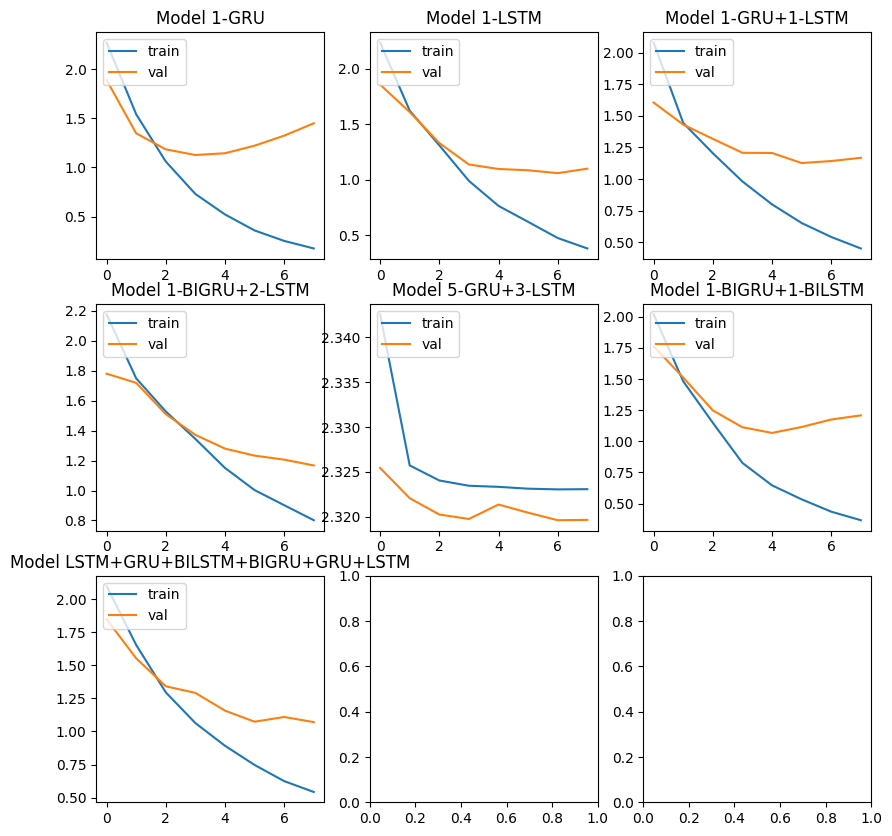

In [65]:
figure, axis = plt.subplots(3, 3, figsize=[10, 10])
j = 0

for i, m in enumerate(models):
# summarize history for accuracy
    axis[j, i%3].plot(m.history.history['loss'])
    axis[j, i%3].plot(m.history.history['val_loss'])
    axis[j, i%3].legend(['train', 'val'], loc='upper left')
    axis[j, i%3].set_title(f"Model {index[i]}")
    if i % 3 == 2:
        j += 1

plt.show()

Как видно, модель LSTM+GRU+BILSTM+BIGRU+GRU+LSTM при более долгом обучении может достигнуть лучших результатов, в то время как однослойная лстм модель достигла своих лучших результатов.

Однослойная гру модель достаточно быстро переобучается, примерно после 5 эпохи. Модель с 5-ю гру и 3-мя лстм слоями не сходится, возможно, для нее стоит выбрать другие параметры обучения, например другой лернинг рейт.

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.

2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
! pip install datasets

**Загружаем данные**

In [68]:
from datasets import load_dataset
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [69]:
i = 100
dataset['train']['tokens'][i], dataset['train']['ner_tags'][i]

(['Был',
  'женат',
  ',',
  'имел',
  'четырёх',
  'детей',
  ',',
  'вместе',
  'с',
  'семьёй',
  'проживал',
  'в',
  'городке',
  'Оквилле',
  '.'],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0])

**Готовим данные**

In [70]:
from collections import Counter
import tensorflow as tf

vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

filtered_vocab = set([word for word in vocab if vocab[word] > 30])
word2id = {word: i + 2 for i, word in enumerate(filtered_vocab)}
word2id['PAD'] = 0
word2id['UNK'] = 0
id2word = {i: word for word, i in word2id.items()}

def text_in_idx_generator(texts):
    global word2id
    for sent in texts['tokens']:
        tokens = [w.lower() for w in sent]
        ids = [word2id.get(token, 1) for token in tokens]
        yield ids

X_train = list(text_in_idx_generator(dataset['train']))
MAX_LEN = max(len(x) for x in X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LEN, padding='post')

X_test = list(text_in_idx_generator(dataset['test']))
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [71]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [ ]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [72]:
y_train = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [82]:
y_train[0].shape

(54,)

**Вспомогательные функции**

In [73]:
import re

def tokenize(text, word2id):
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

**Модель с несколькими BILSTM слоями**

In [83]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model8 = tf.keras.Model(inputs=inputs, outputs=outputs)
model8.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [84]:
model8.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 54)]              0         
                                                                 
 embedding_15 (Embedding)    (None, 54, 100)           32500     
                                                                 
 bidirectional_13 (Bidirecti  (None, 54, 256)          234496    
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 54, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 54, 256)          394240    
 onal)                                                           
                                                          

In [85]:
model8.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=10)

Epoch 1/10
157/157 [==============================] - 40s 171ms/step - loss: 0.2382 - accuracy: 0.9323 - val_loss: 0.1514 - val_accuracy: 0.9528
Epoch 2/10
157/157 [==============================] - 8s 49ms/step - loss: 0.1399 - accuracy: 0.9545 - val_loss: 0.1269 - val_accuracy: 0.9575
Epoch 3/10
157/157 [==============================] - 8s 48ms/step - loss: 0.1148 - accuracy: 0.9624 - val_loss: 0.1012 - val_accuracy: 0.9677
Epoch 4/10
157/157 [==============================] - 7s 46ms/step - loss: 0.0881 - accuracy: 0.9718 - val_loss: 0.0744 - val_accuracy: 0.9754
Epoch 5/10
157/157 [==============================] - 6s 39ms/step - loss: 0.0689 - accuracy: 0.9772 - val_loss: 0.0652 - val_accuracy: 0.9783
Epoch 6/10
157/157 [==============================] - 7s 44ms/step - loss: 0.0638 - accuracy: 0.9787 - val_loss: 0.0658 - val_accuracy: 0.9782
Epoch 7/10
157/157 [==============================] - 7s 43ms/step - loss: 0.0602 - accuracy: 0.9796 - val_loss: 0.0615 - val_accuracy: 0.97

**Графики обучения модели**

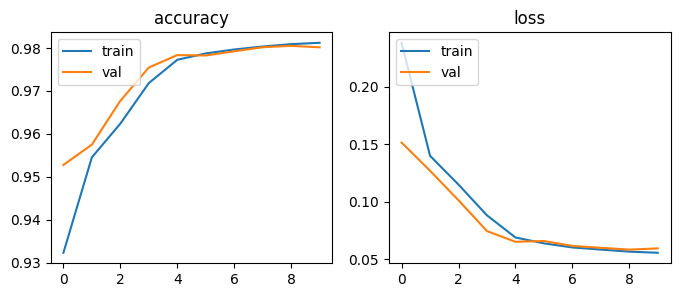

In [91]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=[8, 3])
# summarize history for accuracy
axis[0].plot(model8.history.history['accuracy'])
axis[0].plot(model8.history.history['val_accuracy'])
axis[0].legend(['train', 'val'], loc='upper left')
axis[0].set_title('accuracy')

axis[1].plot(model8.history.history['loss'])
axis[1].plot(model8.history.history['val_loss'])
axis[1].legend(['train', 'val'], loc='upper left')
axis[1].set_title('loss')

plt.show()

In [92]:
score = model8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.059400543570518494
Test accuracy: 0.9801499843597412


**Модель с несколькими BIGRU слоями**

In [93]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
gru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(gru_1)
gru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(gru_2)
gru_4 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(gru_3)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru_4)

model9 = tf.keras.Model(inputs=inputs, outputs=outputs)
model9.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [94]:
model9.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=10)

Epoch 1/10
157/157 [==============================] - 39s 110ms/step - loss: 0.2171 - accuracy: 0.9349 - val_loss: 0.1205 - val_accuracy: 0.9614
Epoch 2/10
157/157 [==============================] - 8s 52ms/step - loss: 0.0884 - accuracy: 0.9707 - val_loss: 0.0714 - val_accuracy: 0.9768
Epoch 3/10
157/157 [==============================] - 9s 55ms/step - loss: 0.0659 - accuracy: 0.9779 - val_loss: 0.0706 - val_accuracy: 0.9778
Epoch 4/10
157/157 [==============================] - 8s 48ms/step - loss: 0.0617 - accuracy: 0.9791 - val_loss: 0.0611 - val_accuracy: 0.9796
Epoch 5/10
157/157 [==============================] - 8s 51ms/step - loss: 0.0584 - accuracy: 0.9801 - val_loss: 0.0593 - val_accuracy: 0.9799
Epoch 6/10
157/157 [==============================] - 7s 45ms/step - loss: 0.0571 - accuracy: 0.9805 - val_loss: 0.0584 - val_accuracy: 0.9801
Epoch 7/10
157/157 [==============================] - 10s 62ms/step - loss: 0.0554 - accuracy: 0.9811 - val_loss: 0.0592 - val_accuracy: 0.9

**Графики обучения модели**

Почему-то keras решил не отдавать историю обучения модельки, хотя до этого все шло хорошо

In [105]:
print(model9.history.history)

{}


In [103]:
score = model9.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.055602509528398514
Test accuracy: 0.9809055328369141


Как видно, обе модели хорошо обучились, но вторая модель с би-гру слоями все же чуть лучше

**Сравнение на сложных примерах**

In [106]:
! pip install ipymarkup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26099 sha256=02da3d3cf12ce752b1ad4041f527701e760c5a22e5bdee7ff6006bb169f06e98
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [107]:
from ipymarkup import show_span_box_markup

In [108]:
example1 = "Представляя спикера, проректор НИУ ВШЭ Елена Одоевская подчеркнула, что Дарья Кирьянова до прихода в министерство долгое время работала в бизнесе — в корпорации Intel на различных позициях."
example2 = "Рядом весело бежали псы его, которых звали: Караул, Пожар, Дружок, Чемодан и Пирожок, Рыже-огненный Кидай и огромный Угадай."
example3 = "Эрих Мария Ремарк был женат на Ильзе Ютте Замбоне, но брак был фиктивным. "

In [109]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model9)

1/1 [==============================] - 7s 7s/step


[('Алексей', 'B-PER'),
 ('сказал', 'O'),
 ('Светлане', 'O'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('она', 'O'),
 ('собиралась', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'O'),
 ('.', 'O')]

In [127]:
def get_markup(example):
    markup_1 = label_seq(example, word2id, id2labels, MAX_LEN, model8)
    markup_2 = label_seq(example, word2id, id2labels, MAX_LEN, model9)
    spans1 = []
    spans2 = []
    for i, (word, tag) in enumerate(markup_1):
        idx1 = example.index(word)
        idx2 = idx1 + len(word)
        if tag != 'O':
            spans1.append((idx1, idx2, tag))
        if markup_2[i][1] != 'O':
            spans2.append((idx1, idx2, markup_2[i][1]))
    show_span_box_markup(example, spans1)
    show_span_box_markup(example, spans2)

In [128]:
get_markup(example1)

1/1 [==============================] - 0s 33ms/step


In [129]:
get_markup(example2)

1/1 [==============================] - 0s 42ms/step


In [130]:
get_markup(example3)

1/1 [==============================] - 0s 135ms/step


***Пример 1***

Не распознаются имя и фамилия, стоящие внутри предложения, в целом, а не только те, которые сопровождаются приложением (*проректор НИУ ВШЭ*). Зато второй моделью токен *минестерство* распознаётся как организация, хотя она расширяет эту сущность до *минестерство долгое*, что неверно. Первая же модель неверно приписывает ему тег локации, как и токену *бизнес*

***Пример 2***

Сложные клички лучше распознаются первой моделью, хотя и не все. Вторая модель, хоть и выделяет их как именованные сущности, приписывает им не те теги.

***Пример 3***

Составные иностранные имена распознаются в начале предложения, но не в середине / конце. Также первому токену не приписывается нужный тег "B-PER".